In [1]:
import os, sys
sys.path.insert(0, '/Users/kv/workspace/kv-capstone/NBAwinshare/source')

from source import seasonalregressor
from source import data_wrangle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error
import importlib
from source.helper_functions import weighted_mean_multi_col_weight as wm2

%matplotlib inline

## Read in Data

Read in NBA player data into various dataframes, and join them in the "fullstats" dataframe.

In [2]:
advanced = data_wrangle.read_all_advanced('./data/advanced')
pergame  = data_wrangle.read_all_pergame('./data/per_game')
seasonal = data_wrangle.clean_and_join_seasonal_dataframe(advanced, pergame)
demographic = data_wrangle.read_demographic_data('./data/player_data.csv')
fullstats = data_wrangle.add_years_in_league(seasonal, demographic)


The test and train sets are split up by player name. For consistency, I saved the test and train set names in a pickle object so that I would not have to re-run a train/test split in every new notebook iteration 

In [3]:
with open('train_test.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    trainnames, testnames = pickle.load(f)
    

Get the actual Win-Shares for players in the test set for scoring purposes.

In [4]:
actuals = data_wrangle.get_actuals_for_years_5_thru_9(fullstats, testnames)

## Use the Seasonal Regressor to Fit and Predict Future Performance

Based on my initial grid-search, I am using only a small subset of fields to train the random forest predictors in the Seasonal Regressor object:

OBPM - Offensive Box-plus-minus

FGA  - Field goal attempts per game (2's and 3's)

DRB  - Defensive rebounds per game

2P   - Two pointers attempted per game

FG   - Field goals made per game

In [5]:
cols_to_train_from_feature_search = ['OBPM', 'FGA', 'DRB', '2P', 'FG']

My grid-search aslo indicated that the best averaging method for seasons 1-4 was to use weights of season-number * games played in that season, which the wm2 function provides.

In [6]:
sr = seasonalregressor.SeasonalRegressor(columns_to_train=cols_to_train_from_feature_search, function=wm2)

Create the train-test split dataframes, utilizing the Seasonal Regressor method.

In [7]:
fulltrain, fulltest = sr.create_train_test_split(fullstats, trainnames, testnames)

Fit the Seasonal Regressor to the training data.

In [8]:
sr = sr.fit(fulltrain)

Now, let's predict the win-shares of the test set.  The *predict* method returns a dictionary of results, with the player name as the key and a list of predictions as the values.  

The *unpack_prediction_dictionary* method converts that prediction-dictionary to a single list of predictions.

In [9]:
pred_dict = sr.predict(fulltest)
predictions = sr.unpack_prediction_dictionary(pred_dict)

Calculate the mean-squared-error for the test set.

In [10]:
score = mean_squared_error(actuals, predictions)
print("Mean-squared error: ", score)
print("Average error:      ", score**.5)

Mean-squared error:  6.771893367741934
Average error:       2.6022861809843154


The average error indicates that the model is off by 2.6 win-shares per player per year.

## The LBJ Effect
LeBron is an outlier, and just so happens to be in the train set.  

I also performed a hierarchical clustering analysis with player data from years one through four.  Hierarchical clustering iteratively groups observations (here, players) together based on their similarities.  These similiarities are displayed on a dendrogram.  The height of connections between players indicates their similarity--the lower the height of the connection, the more similar the players are.

This dendrogram shows the linkage between players using "average" linkage--which means that the distance between two clusters is the average distance between each point in one cluster to another. For a distance metric, I used Eucilidean distance (the straight-line distance between two points).

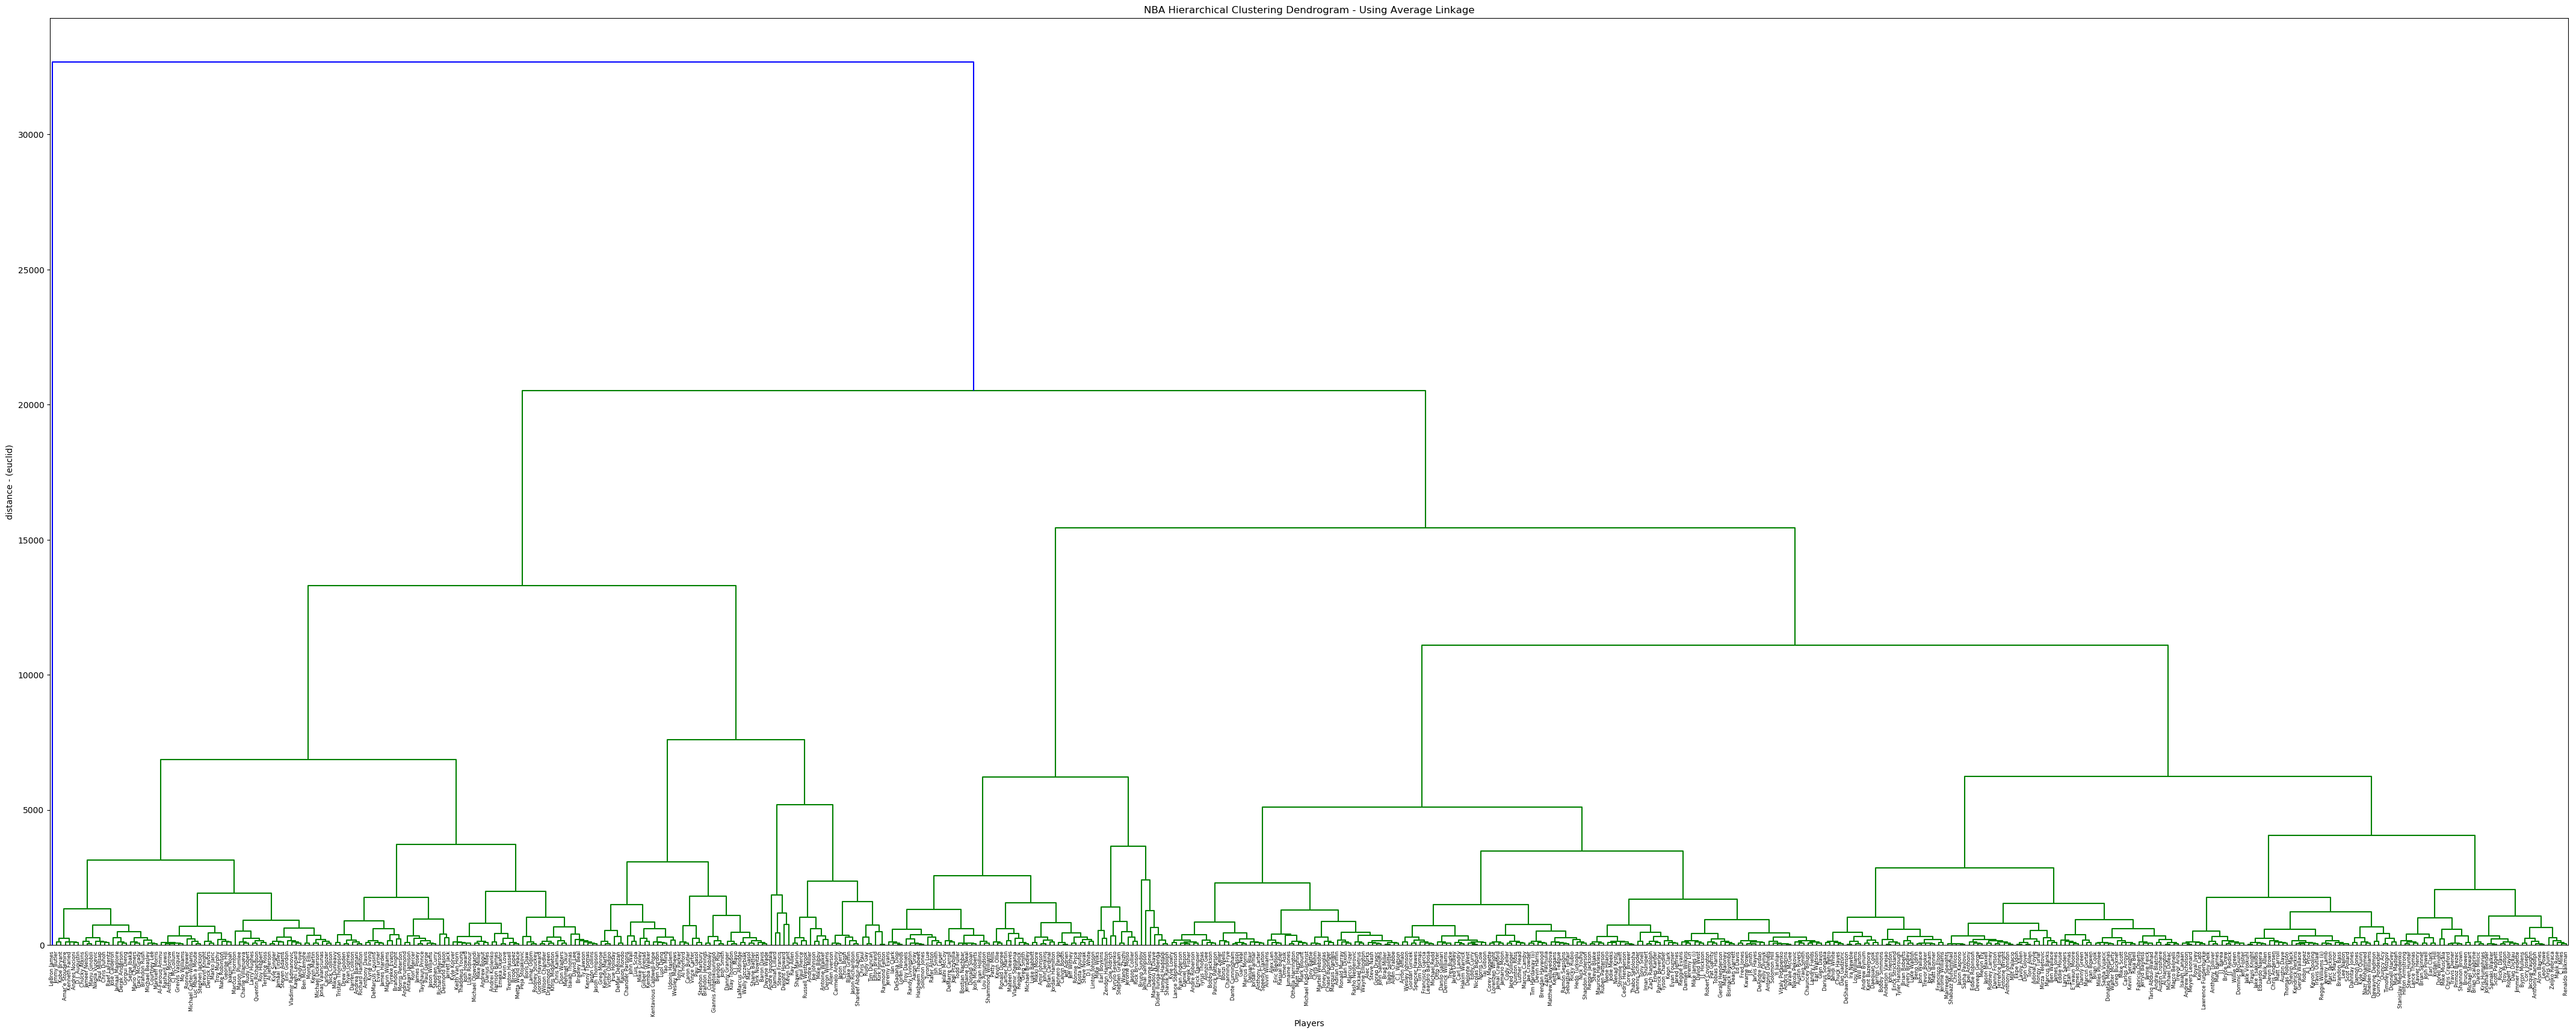

LBJ is in a hierarchical cluster all by himself--he's the blue line on the far left side of the plot.  Just in case you did not believe that he is a singular talent--especially in his first four years in the Association--this plot shows otherwise.

Given LBJ's outlier status, how much does his presence in the training set affect the scoring on the predict method?

Let's filter LeBron out of the training set and test again.

In [11]:
LBJ_less_train = fulltrain[fulltrain['Player'] != 'LeBron James']

We'll repeat the same process--instantiate a SeasonalRegressor object, use the non-LBJ data to train, and predict the test-set.

In [12]:
sr_no_LBJ = seasonalregressor.SeasonalRegressor(columns_to_train=cols_to_train_from_feature_search, function=wm2)
sr_no_LBJ = sr_no_LBJ.fit(LBJ_less_train)
pred_dict_noLBJ = sr_no_LBJ.predict(fulltest)
predictions_noLBJ = sr_no_LBJ.unpack_prediction_dictionary(pred_dict_noLBJ)

In [13]:
score_no_lbj = mean_squared_error(actuals, predictions_noLBJ)
print("Mean-squared error: ", score_no_lbj)
print("Average error:      ", score_no_lbj**.5)
print("Percent difference: ", abs(score_no_lbj-score)/score*100)

Mean-squared error:  6.877057645161289
Average error:       2.6224144686073725
Percent difference:  1.552952353330116


Based on these training features, LBJ doesn't seem to significantly affect the predictions.  Because the underlying predictors are Random Forests, that's the behavior I would expect--as Random Forests are not as sensitive to outliers as other regression models.  

I have included some error scores from three previous models--both with and without LBJ in the train set.  As you can see, the errors are slightly better with LBJ excluded from training--with this specific prediction.

In [14]:
without_lbj = np.array([8.877875825806452, 8.746958432258065, 8.663819967741937])
with_lbj = np.array([9.222733341935486, 8.85425506451613, 8.69500149032258])
percent_changes = list((without_lbj-with_lbj)/with_lbj*100)

## Individual Player Performance Predictions

Let's plot some individual player predictions.  First, let's see who is in the test-set.

In [15]:
sorted(testnames)

['Andrea Bargnani',
 'Andris Biedrins',
 'Antawn Jamison',
 'Brian Cook',
 'Brook Lopez',
 'Bruce Bowen',
 'Cuttino Mobley',
 'Dwyane Wade',
 'Earl Boykins',
 'Erick Strickland',
 'Francisco Garcia',
 'Goran Dragic',
 'Jake Voskuhl',
 'Jared Jeffries',
 'Jason Williams',
 'Kirk Hinrich',
 'Kobe Bryant',
 'Kris Humphries',
 'Mike Dunleavy',
 'Raef LaFrentz',
 'Rasual Butler',
 'Robin Lopez',
 'Sasha Pavlovic',
 'Shannon Brown',
 'Shawn Marion',
 'Spencer Hawes',
 'Stephon Marbury',
 'Steve Nash',
 'Tony Battie',
 'Tyronn Lue',
 'Vitaly Potapenko']

### Hall-of-Famers
Let's start with the future (or current) Hall-of-Famers / MVP Winners.

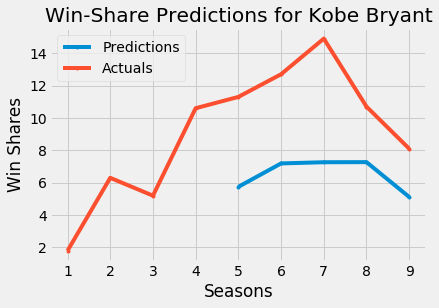

In [16]:
sr.plot_player_arc(fullstats, 'Kobe Bryant', pred_dict)

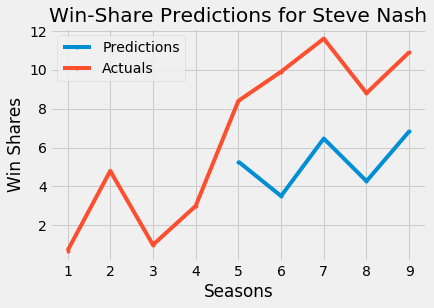

In [17]:
sr.plot_player_arc(fullstats, 'Steve Nash', pred_dict)

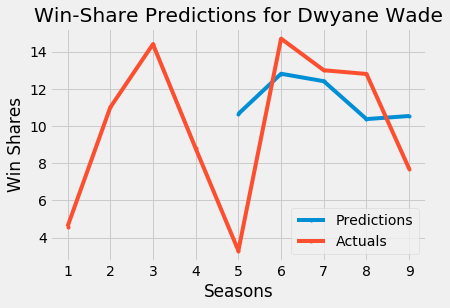

In [18]:
sr.plot_player_arc(fullstats, 'Dwyane Wade', pred_dict)

D-Wade had a really odd 5th year in terms of actual Win-Shares, but he quickly returned to form in year 6.

### Some Good-But-Not-All-World Players

Let's look at guys that are All-Star caliber, or close to being All-Star caliber

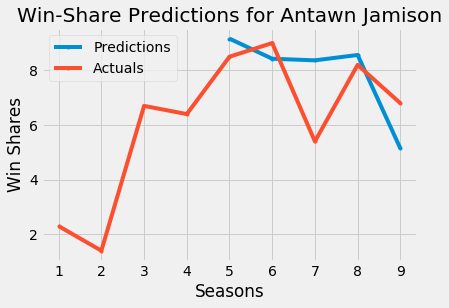

In [19]:
sr.plot_player_arc(fullstats, 'Antawn Jamison', pred_dict)

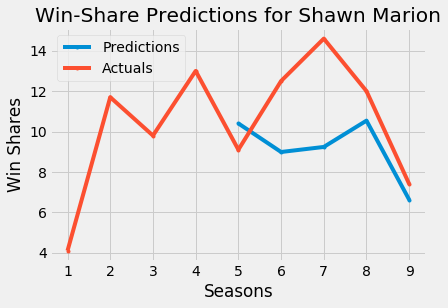

In [20]:
sr.plot_player_arc(fullstats, 'Shawn Marion', pred_dict)

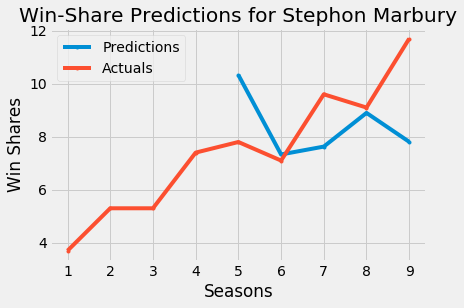

In [21]:
sr.plot_player_arc(fullstats, 'Stephon Marbury', pred_dict)

### Some Solid Players 

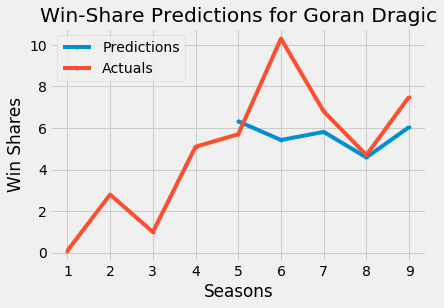

In [22]:
sr.plot_player_arc(fullstats, 'Goran Dragic', pred_dict)

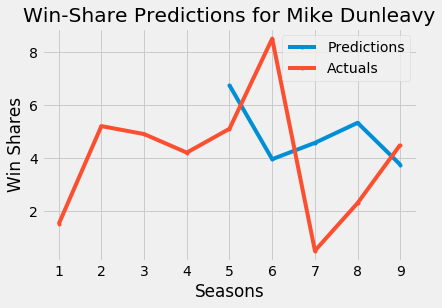

In [23]:
sr.plot_player_arc(fullstats, 'Mike Dunleavy', pred_dict)

Dunleavy only played 18 games in his 7th season--he suffered a knee injury.

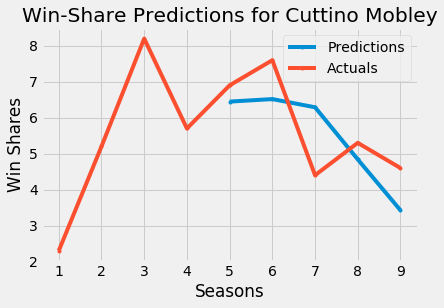

In [24]:
sr.plot_player_arc(fullstats, 'Cuttino Mobley', pred_dict)

### Closer-to-Replacement-Level Players

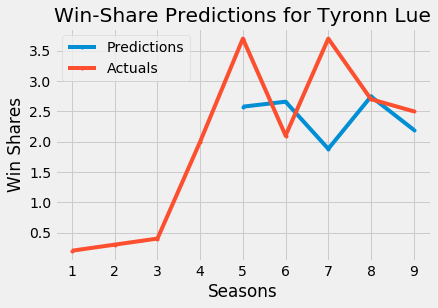

In [25]:
sr.plot_player_arc(fullstats, 'Tyronn Lue', pred_dict)

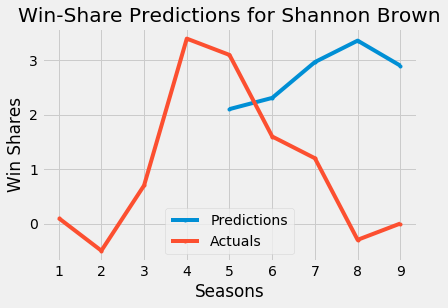

In [26]:
sr.plot_player_arc(fullstats, 'Shannon Brown', pred_dict)

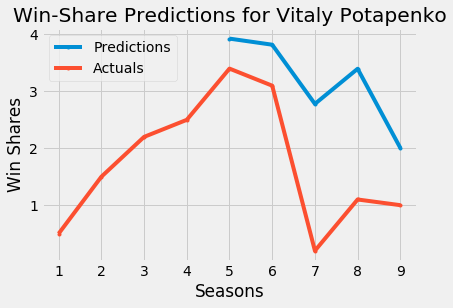

In [27]:
sr.plot_player_arc(fullstats, 'Vitaly Potapenko', pred_dict)

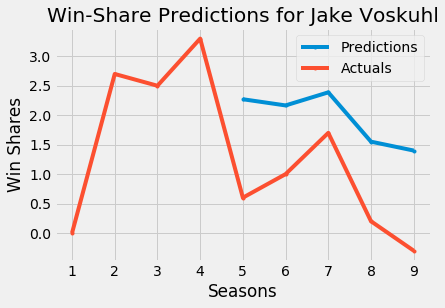

In [28]:
sr.plot_player_arc(fullstats, 'Jake Voskuhl', pred_dict)

From these plots, it appears that the model underpredicts win-shares for top-level players, overpredicts win-shares for replacement-level players, and predicts decently for mid-level to better players.

## Predicting New Players

Let's see some results for newer players.  We'll start with Andrew Wiggins--a player that has received a super-max rookie extension, despite being a less-than-super-efficient player.

First, we'll gather Wiggins's first four-years stats, which *get_single_player_first_x_full_years* retrieves by default.

In [29]:
singleplayerframe = sr.get_single_player_first_x_full_years(fullstats,'Andrew Wiggins')

Let's predict Wiggins's future performance and plot it.

In [30]:
pred_dict = sr.predict(singleplayerframe)

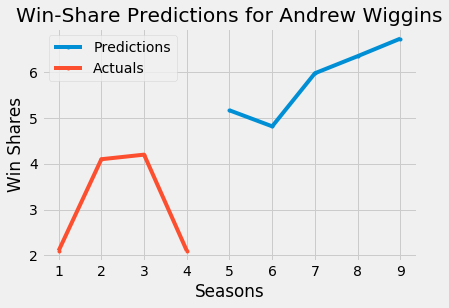

In [31]:
sr.plot_player_arc(fullstats,'Andrew Wiggins',pred_dict)

The model is fairly optimistic about Wiggins's future.  Perhaps with Butler out of the picture in Minnesota, Wiggins might actually earn that super-max deal.

Let's predict some other players.

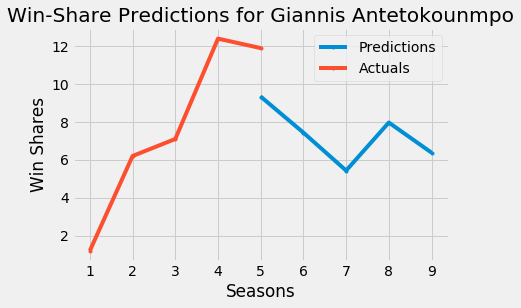

In [32]:
singleplayerframe = sr.get_single_player_first_x_full_years(fullstats,'Giannis Antetokounmpo')
pred_dict = sr.predict(singleplayerframe)
sr.plot_player_arc(fullstats,'Giannis Antetokounmpo',pred_dict)


Looks like the model will significantly underpredict Giannis.  That's inline with the general underprediction for elite players.

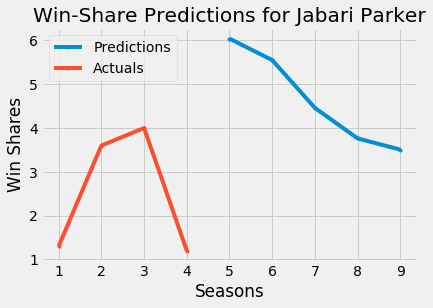

In [33]:
singleplayerframe = sr.get_single_player_first_x_full_years(fullstats,'Jabari Parker')
pred_dict = sr.predict(singleplayerframe)
sr.plot_player_arc(fullstats,'Jabari Parker',pred_dict)

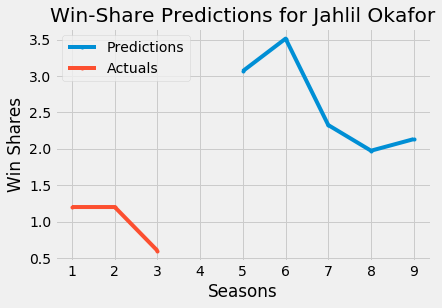

In [34]:
singleplayerframe = sr.get_single_player_first_x_full_years(fullstats,'Jahlil Okafor')
pred_dict = sr.predict(singleplayerframe)
sr.plot_player_arc(fullstats,'Jahlil Okafor',pred_dict)

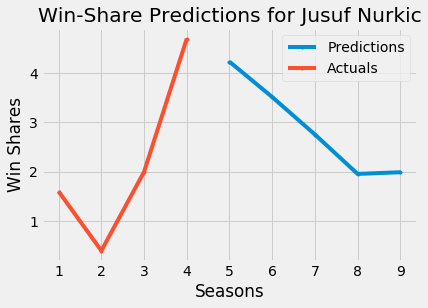

In [35]:
singleplayerframe = sr.get_single_player_first_x_full_years(fullstats,'Jusuf Nurkic')
pred_dict = sr.predict(singleplayerframe)
sr.plot_player_arc(fullstats,'Jusuf Nurkic',pred_dict)

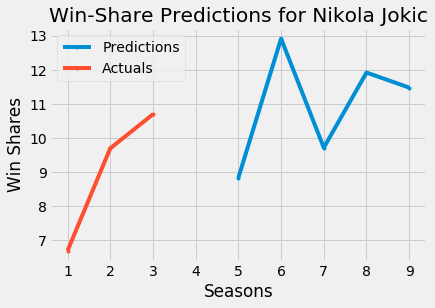

In [36]:
singleplayerframe = sr.get_single_player_first_x_full_years(fullstats,'Nikola Jokic')
pred_dict = sr.predict(singleplayerframe)
sr.plot_player_arc(fullstats,'Nikola Jokic',pred_dict)

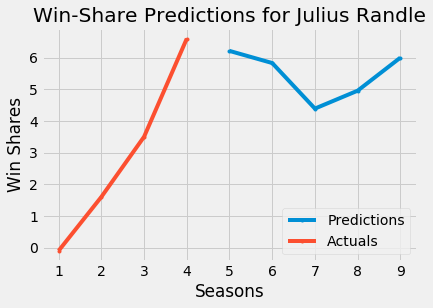

In [37]:
singleplayerframe = sr.get_single_player_first_x_full_years(fullstats,'Julius Randle')
pred_dict = sr.predict(singleplayerframe)
sr.plot_player_arc(fullstats,'Julius Randle',pred_dict)

## Closest Player Comparisons 

Using KNN, let's figure out who are the "closest" players to invididual players, based on their first four seasons, using these stats in *cols_for_similarity*.  I selected these stats because they were the 22-most correlated statistics with Win-Shares (including Win-Shares, and its closely related stats--Offensive Win Shares and Defensive Win Shares).

In [38]:
cols_for_similarity = ['WS',
 'OWS',
 'VORP',
 'DWS',
 'MP_total',
 'PS/G',
 'FG',
 'MP_pergame',
 'GS',
 'FT',
 '2P',
 'FTA',
 'FGA',
 '2PA',
 'DRB',
 'TRB',
 'BPM',
 'G',
 'TOV',
 'STL',
 'PER',
 'OBPM']

First, we'll create a dataframe for all players for their stats--averaged with the same methodology used for our train and predict algorithms.  

In [39]:
df = sr.create_avg_dataframe_for_first_four_seasons(fullstats,columns_to_use=cols_for_similarity)

I'll import the clustering module I wrote that leverages KNN to find most similar players.

In [40]:
import clustering

The *get_x_nearest_players* function returns a dictionary where the key is each player, stored in a string, and the value is a list of the most similar players (again, each player is a string).

In [41]:
similar_players = clustering.get_x_nearest_players(df, x = 5)

Let's see who similar players are for some notable players.

In [42]:
print(similar_players['Dirk Nowitzki'])

['Blake Griffin', 'Elton Brand', 'Karl-Anthony Towns', 'Giannis Antetokounmpo', 'Brandon Roy']


In [43]:
print(similar_players['Kobe Bryant'])

['Richard Jefferson', 'Tracy McGrady', 'Danny Granger', 'Anfernee Hardaway', 'Cuttino Mobley']


In [44]:
print(similar_players['LeBron James'])

['Grant Hill', 'Dwyane Wade', 'Kevin Durant', 'Paul Pierce', 'Chris Paul']


In [45]:
print(similar_players['Kawhi Leonard'])

['Draymond Green', 'Josh Howard', 'Rashard Lewis', 'Rajon Rondo', 'Wesley Person']


In [46]:
print(similar_players['Giannis Antetokounmpo'])

['Richard Jefferson', 'Marc Gasol', 'Andre Iguodala', 'Tracy McGrady', 'Pau Gasol']


In [47]:
print(similar_players['Derrick Rose'])

['Russell Westbrook', 'Kyrie Irving', 'Tracy McGrady', 'Damian Lillard', 'Brandon Roy']


In [48]:
print(similar_players['Russell Westbrook'])

['John Wall', 'Gilbert Arenas', 'Derrick Rose', 'Anfernee Hardaway', 'Kyrie Irving']


In [49]:
print(similar_players['Stephen Curry'])

['Jason Terry', 'Ray Allen', 'Kyrie Irving', 'Deron Williams', 'Anfernee Hardaway']


In [50]:
print(similar_players['Klay Thompson'])

['CJ McCollum', 'Tony Parker', 'Chandler Parsons', 'Joe Johnson', 'Brandon Jennings']


In [51]:
print(similar_players['Tim Duncan'])

['Grant Hill', 'Blake Griffin', 'Dwight Howard', 'Vin Baker', 'Elton Brand']


In [52]:
print(similar_players['Greg Oden'])

['Andrew Bynum', 'Terrence Jones', 'Marcus Camby', 'JaVale McGee', 'Danny Fortson']


In [53]:
print(similar_players['J.J. Barea'])

['Beno Udrih', 'Wayne Ellington', 'Eldridge Recasner', 'Brian Roberts', 'Jason Kapono']


## 2014 NBA Draft Class

Let's get similar players for some of the notable players in the 2014 Draft class--as these are the players at the 4-year decision point going into the 2018-2019 NBA Season.

In [54]:
print(similar_players['Andrew Wiggins'])

['DeMar DeRozan', 'Richard Hamilton', 'Devin Booker', 'Ron Mercer', 'Rudy Gay']


In [55]:
print(similar_players['Jabari Parker'])

['T.J. Warren', 'Tobias Harris', 'Michael Beasley', 'Wilson Chandler', 'Corliss Williamson']


In [56]:
print(similar_players['Joel Embiid'])

['DeMarcus Cousins', 'Shareef Abdur-Rahim', 'Antonio McDyess', 'Chris Bosh', 'Pau Gasol']


In [57]:
print(similar_players['Aaron Gordon'])

['Donyell Marshall', 'Tobias Harris', 'Kenny Thomas', 'Willie Cauley-Stein', 'Markieff Morris']


In [58]:
print(similar_players['Dante Exum'])

['Sasha Pavlovic', 'Donte Greene', 'Antoine Wright', 'Nik Stauskas', 'DerMarr Johnson']


In [59]:
print(similar_players['Marcus Smart'])

['Marko Jaric', 'Caris LeVert', 'Eric Bledsoe', 'Chris Childs', 'Delonte West']


In [60]:
print(similar_players['Julius Randle'])

['Andrew Bogut', 'Zach Randolph', 'Drew Gooden', 'Troy Murphy', 'Brian Grant']


In [61]:
print(similar_players['Nik Stauskas'])

['Dante Exum', 'Isaiah Canaan', 'Donte Greene', 'Hollis Thompson', 'DerMarr Johnson']


In [62]:
print(similar_players['Doug McDermott'])

['Jason Kapono', 'Wayne Ellington', 'Rasual Butler', 'Mike Scott', 'James Robinson']


In [63]:
print(similar_players['Dario Saric'])

['Mike Dunleavy', 'Aaron Gordon', 'Markieff Morris', 'Matt Harpring', 'Jeff Green']


In [64]:
print(similar_players['Jusuf Nurkic'])

['Donyell Marshall', 'Roy Hibbert', 'Zydrunas Ilgauskas', 'Chris Kaman', 'Jared Sullinger']


In [65]:
print(similar_players['Clint Capela'])

['Kenneth Faried', 'Serge Ibaka', 'Jonas Valanciunas', 'Andris Biedrins', 'David Lee']


In [66]:
print(similar_players['Nikola Jokic'])

['Al Horford', 'Giannis Antetokounmpo', 'Marc Gasol', 'Dirk Nowitzki', 'Elton Brand']
